In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
import math

SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,2): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"

In [19]:
class SceneChangeDetector:
    def __init__(self, clip_features, timestamps):
        self.clip_features = clip_features
        self.timestamps = timestamps
        self.distances = None
        self.scene_changes = None
        
    def compute_frame_distances(self, metric='cosine'):
        """Compute distances between consecutive frames"""
        distances = []
        
        for i in range(1, len(self.clip_features)):
            if metric == 'cosine':
                # Cosine distance (1 - cosine similarity)
                dist = cosine(self.clip_features[i-1], self.clip_features[i])
            elif metric == 'euclidean':
                # Euclidean distance
                dist = euclidean(self.clip_features[i-1], self.clip_features[i])
            elif metric == 'l1':
                # L1 (Manhattan) distance
                dist = np.sum(np.abs(self.clip_features[i-1] - self.clip_features[i]))
            
            distances.append(dist)
            
        self.distances = np.array(distances)
        return self.distances
    
    def detect_scene_changes(self, threshold_method='adaptive', threshold=None, 
                           prominence=None, distance=None):
        """Detect scene changes using peak detection"""
        if self.distances is None:
            self.compute_frame_distances()
            
        if threshold_method == 'adaptive':
            # Use mean + k*std as threshold
            threshold = np.mean(self.distances) + 2 * np.std(self.distances)
        elif threshold_method == 'percentile':
            # Use percentile-based threshold
            threshold = np.percentile(self.distances, 95)
        
        # Find peaks in the distance signal
        peaks, properties = find_peaks(
            self.distances, 
            height=threshold,
            prominence=prominence,
            distance=distance
        )
        
        # Convert frame indices to timestamps
        scene_change_times = [self.timestamps[i+1] for i in peaks]  # +1 because distances are offset
        
        self.scene_changes = {
            'frame_indices': peaks + 1,  # +1 to account for distance offset
            'timestamps': scene_change_times,
            'distances': self.distances[peaks],
            'threshold': threshold
        }
        
        return self.scene_changes
    
    def plot_distance_timeline(self, figsize=(15, 8)):
        """Plot the distance timeline with detected scene changes"""
        if self.distances is None:
            self.compute_frame_distances()
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1])
        
        # Plot 1: Distance over time
        time_points = self.timestamps[1:]  # Skip first timestamp since distances start from frame 1
        ax1.plot(time_points, self.distances, linewidth=0.8, color='blue', alpha=0.7)
        ax1.set_ylabel('Frame Distance')
        ax1.set_title('Scene Change Detection from CLIP Features')
        ax1.grid(True, alpha=0.3)
        
        # Add scene change markers
        if self.scene_changes is not None:
            ax1.axhline(y=self.scene_changes['threshold'], color='red', 
                       linestyle='--', alpha=0.7, label=f"Threshold: {self.scene_changes['threshold']:.4f}")
            ax1.scatter(self.scene_changes['timestamps'], self.scene_changes['distances'], 
                       color='red', s=50, zorder=5, label=f"Scene Changes ({len(self.scene_changes['timestamps'])})")
            ax1.legend()
        
        # Plot 2: Scene change indicators
        scene_indicators = np.zeros(len(time_points))
        if self.scene_changes is not None:
            for idx in self.scene_changes['frame_indices']:
                if idx - 1 < len(scene_indicators):  # -1 because distances array is offset
                    scene_indicators[idx - 1] = 1
        
        ax2.fill_between(time_points, scene_indicators, alpha=0.6, color='red')
        ax2.set_ylabel('Scene Change')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylim(-0.1, 1.1)
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['No', 'Yes'])
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_feature_space_pca(self, figsize=(12, 8)):
        """Visualize features in 2D PCA space with scene changes highlighted"""
        # Apply PCA to reduce dimensionality
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(self.clip_features)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create a color map based on time
        colors = plt.cm.viridis(np.linspace(0, 1, len(features_2d)))
        
        # Plot trajectory through feature space
        ax.plot(features_2d[:, 0], features_2d[:, 1], alpha=0.3, color='gray', linewidth=0.5)
        scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], c=self.timestamps, 
                           cmap='viridis', s=20, alpha=0.7)
        
        # Highlight scene changes
        if self.scene_changes is not None:
            scene_points = features_2d[self.scene_changes['frame_indices']]
            ax.scatter(scene_points[:, 0], scene_points[:, 1], 
                      color='red', s=100, marker='x', linewidth=3, 
                      label=f'Scene Changes ({len(scene_points)})')
            ax.legend()
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax.set_title('Movie Frames in CLIP Feature Space (PCA)')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Time (seconds)')
        
        return fig
    
    def plot_distance_histogram(self, figsize=(10, 6)):
        """Plot histogram of frame distances"""
        if self.distances is None:
            self.compute_frame_distances()
            
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.hist(self.distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
        ax.set_xlabel('Frame Distance')
        ax.set_ylabel('Frequency')
        ax.set_title('Distribution of Frame-to-Frame Distances')
        
        if self.scene_changes is not None:
            ax.axvline(x=self.scene_changes['threshold'], color='red', 
                      linestyle='--', linewidth=2, 
                      label=f"Threshold: {self.scene_changes['threshold']:.4f}")
            ax.legend()
        
        ax.grid(True, alpha=0.3)
        return fig
    
    def get_scene_summary(self):
        """Get summary statistics of detected scenes"""
        if self.scene_changes is None:
            return "No scene changes detected yet. Run detect_scene_changes() first."
        
        scene_durations = []
        prev_time = 0
        
        for change_time in self.scene_changes['timestamps']:
            scene_durations.append(change_time - prev_time)
            prev_time = change_time
        
        # Add final scene duration
        scene_durations.append(self.timestamps[-1] - prev_time)
        
        summary = {
            'total_scenes': len(self.scene_changes['timestamps']) + 1,
            'scene_changes': len(self.scene_changes['timestamps']),
            'avg_scene_duration': np.mean(scene_durations),
            'median_scene_duration': np.median(scene_durations),
            'shortest_scene': np.min(scene_durations),
            'longest_scene': np.max(scene_durations),
            'scene_change_times': self.scene_changes['timestamps']
        }
        
        return summary

def analyze_movie_scenes(clip_features, timestamps):
    """Complete analysis pipeline"""
    detector = SceneChangeDetector(clip_features, timestamps)
    
    # Try different distance metrics
    print("Computing frame distances...")
    detector.compute_frame_distances(metric='cosine')  # or 'euclidean', 'l1'
    
    # Detect scene changes
    print("Detecting scene changes...")
    scene_changes = detector.detect_scene_changes(threshold_method='adaptive')
    
    # Generate plots
    print("Generating visualizations...")
    fig1 = detector.plot_distance_timeline()
    # fig2 = detector.plot_feature_space_pca()
    # fig3 = detector.plot_distance_histogram()
    
    # Print summary
    summary = detector.get_scene_summary()
    print("\nScene Analysis Summary:")
    print(f"Total scenes detected: {summary['total_scenes']}")
    print(f"Number of scene changes: {summary['scene_changes']}")
    print(f"Average scene duration: {summary['avg_scene_duration']:.2f} seconds")
    print(f"Median scene duration: {summary['median_scene_duration']:.2f} seconds")
    print(f"Shortest scene: {summary['shortest_scene']:.2f} seconds")
    print(f"Longest scene: {summary['longest_scene']:.2f} seconds")
    
    if summary['scene_changes'] > 0:
        print(f"\nScene change timestamps: {[f'{t:.2f}s' for t in summary['scene_change_times']]}")
    
    plt.show()
    
    return detector, summary, summary['scene_change_times']

In [5]:
def extract_frame_at_time(video_path, timestamp):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    return pil_image


def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    # display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

def get_neural_data_at_index(subject_id, trial_id, electrode, start, end):
    subject = BrainTreebankSubject(subject_id, cache=False)
    neural_data = subject.get_electrode_data(electrode,trial_id,window_from=start, window_to=end)
    return neural_data

In [14]:
def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

def get_subject_trial_from_movie(movie):
    subject_trial_list = []
    for subject_trial, movie_name in SUBJECT_TRIAL_TO_MOVIE.items():
        if movie_name == movie:
            subject_trial_list.append(subject_trial)
    return subject_trial_list

def get_unique_electrodes(electrode_locations):
    unique_electrodes = {}
    seen_values = set()
    
    for key, value in electrode_locations.items():
        if value not in seen_values:
            unique_electrodes[key] = value
            seen_values.add(value)
    
    return list(unique_electrodes.keys())

In [22]:
def graph_scene_changes(movie, start_time, end_time):
    clip_features, timestamps, movie_path = get_movie_data(movie)
    detector, summary, scene_change_times = analyze_movie_scenes(clip_features, timestamps)
    subject_trial_list = get_subject_trial_from_movie(movie)

    for subject_trial in subject_trial_list:
        subject_id, trial_id = subject_trial
        subject = BrainTreebankSubject(subject_id, cache=False)
        electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
        unique_electrodes = get_unique_electrodes(electrode_locations)

        trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{subject_id}_trial{trial_id:03}_timings.csv')
        trigs_df = pd.read_csv(trigger_times_file)
        last_trigger_time = trigs_df['movie_time'].iloc[-1]
        safe_end_timestamp = min(timestamps[-2], last_trigger_time - 1.0)  # 1 second buffer
        # start = obtain_neural_data_index(subject_id, trial_id, np.array([timestamps[0]])).item()
        # end = obtain_neural_data_index(subject_id, trial_id, np.array([safe_end_timestamp])).item()
        # neural_timestamps = timestamps[timestamps <= safe_end_timestamp]

        scene_change_times_filt = np.array(scene_change_times)[np.array(scene_change_times) <= safe_end_timestamp]
        scene_change_indexes = [obtain_neural_data_index(subject_id, trial_id, np.array([t])).item() for t in scene_change_times_filt]

        start_idx = obtain_neural_data_index(subject_id, trial_id, np.array([start_time])).item()
        end_idx = obtain_neural_data_index(subject_id, trial_id, np.array([end_time])).item()
        scene_idxs = [idx for idx in scene_change_indexes if start_idx <= idx <= end_idx]


        ncols = 2  # adjust this for layout
        nrows = math.ceil(len(unique_electrodes) / ncols)

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False)
        fig.suptitle(f'Subject {subject_id}, Trial {trial_id}: Electrode Data with Scene Changes from {start_time}s to {end_time}s', fontsize=16)

        for i, electrode in enumerate(unique_electrodes):
            row = i // ncols
            col = i % ncols
            ax = axes[row][col]

            electrode_data_filt = get_neural_data_at_index(subject_id, trial_id, electrode, start_idx, end_idx)
            ax.plot(range(start_idx, end_idx), electrode_data_filt, label=f'Electrode {electrode}')
            for idx in scene_idxs:
                if idx == scene_idxs[0]:
                    ax.axvline(x=idx, color='r', linestyle='--', alpha=0.7, label='Scene Change')
                else:
                    ax.axvline(x=idx, color='r', linestyle='--', alpha=0.7)
            ax.set_xlabel('Data Index')
            ax.set_ylabel('Electrode Signal')
            ax.set_title(f'Electrode {electrode}: {electrode_locations[electrode]}')
            ax.legend()

        # Hide any unused subplots
        for j in range(i + 1, nrows * ncols):
            row = j // ncols
            col = j % ncols
            fig.delaxes(axes[row][col])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

Computing frame distances...
Detecting scene changes...
Generating visualizations...

Scene Analysis Summary:
Total scenes detected: 3447
Number of scene changes: 3446
Average scene duration: 2.04 seconds
Median scene duration: 1.42 seconds
Shortest scene: 0.08 seconds
Longest scene: 144.27 seconds

Scene change timestamps: ['6.51s', '13.72s', '15.89s', '24.07s', '27.40s', '29.24s', '29.49s', '30.86s', '31.61s', '32.45s', '35.54s', '39.62s', '40.75s', '41.75s', '43.00s', '46.67s', '47.88s', '53.43s', '57.97s', '62.31s', '63.40s', '66.73s', '67.19s', '67.61s', '68.99s', '70.28s', '74.16s', '75.16s', '76.79s', '77.83s', '80.21s', '82.58s', '83.96s', '90.55s', '97.14s', '103.19s', '105.86s', '108.07s', '112.78s', '120.20s', '121.71s', '125.63s', '128.00s', '129.80s', '130.30s', '130.42s', '130.55s', '130.67s', '130.80s', '130.92s', '131.05s', '131.17s', '131.30s', '131.42s', '131.55s', '131.67s', '131.80s', '131.92s', '132.05s', '132.17s', '132.30s', '132.42s', '132.55s', '132.67s', '132.

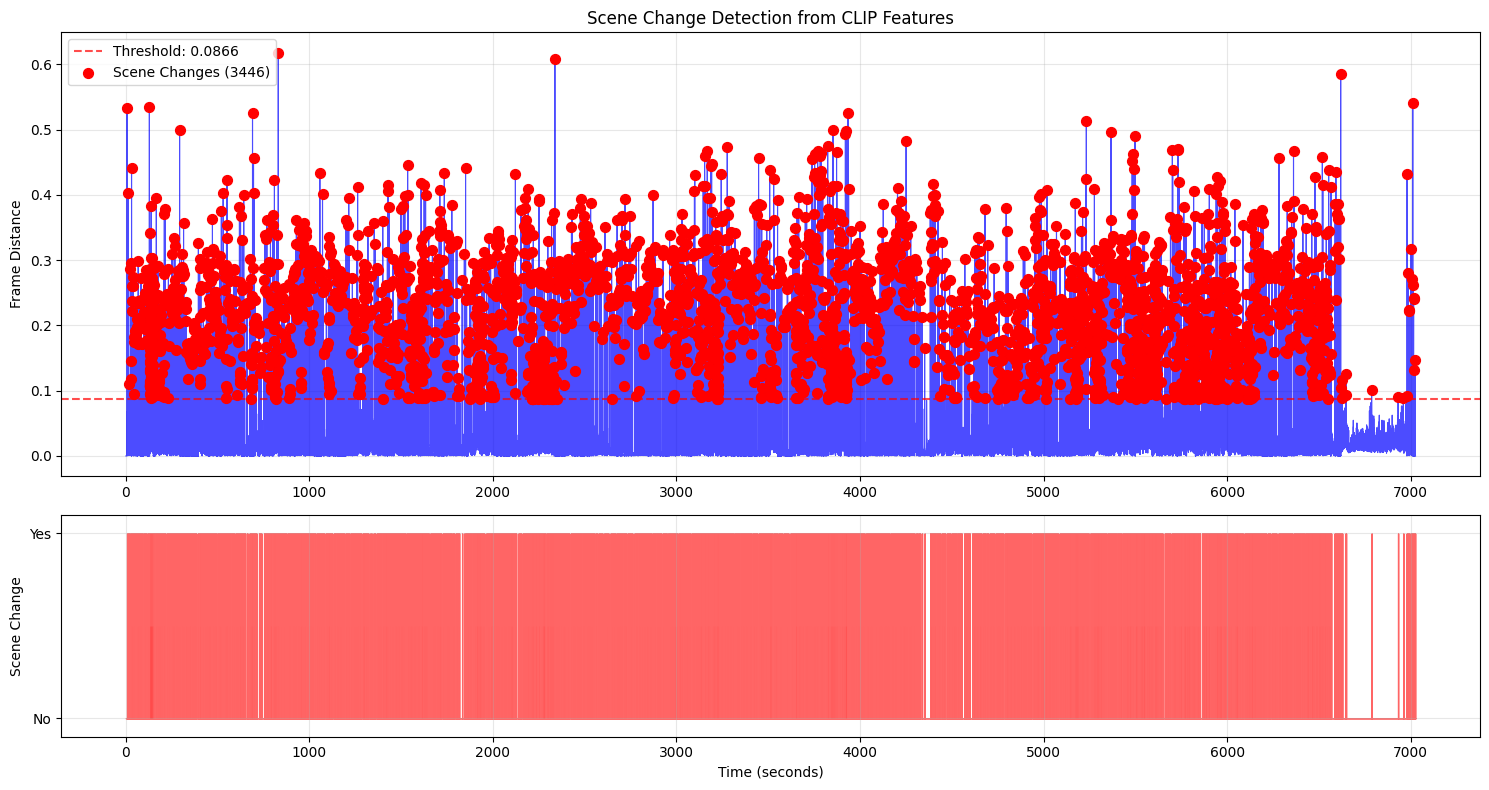

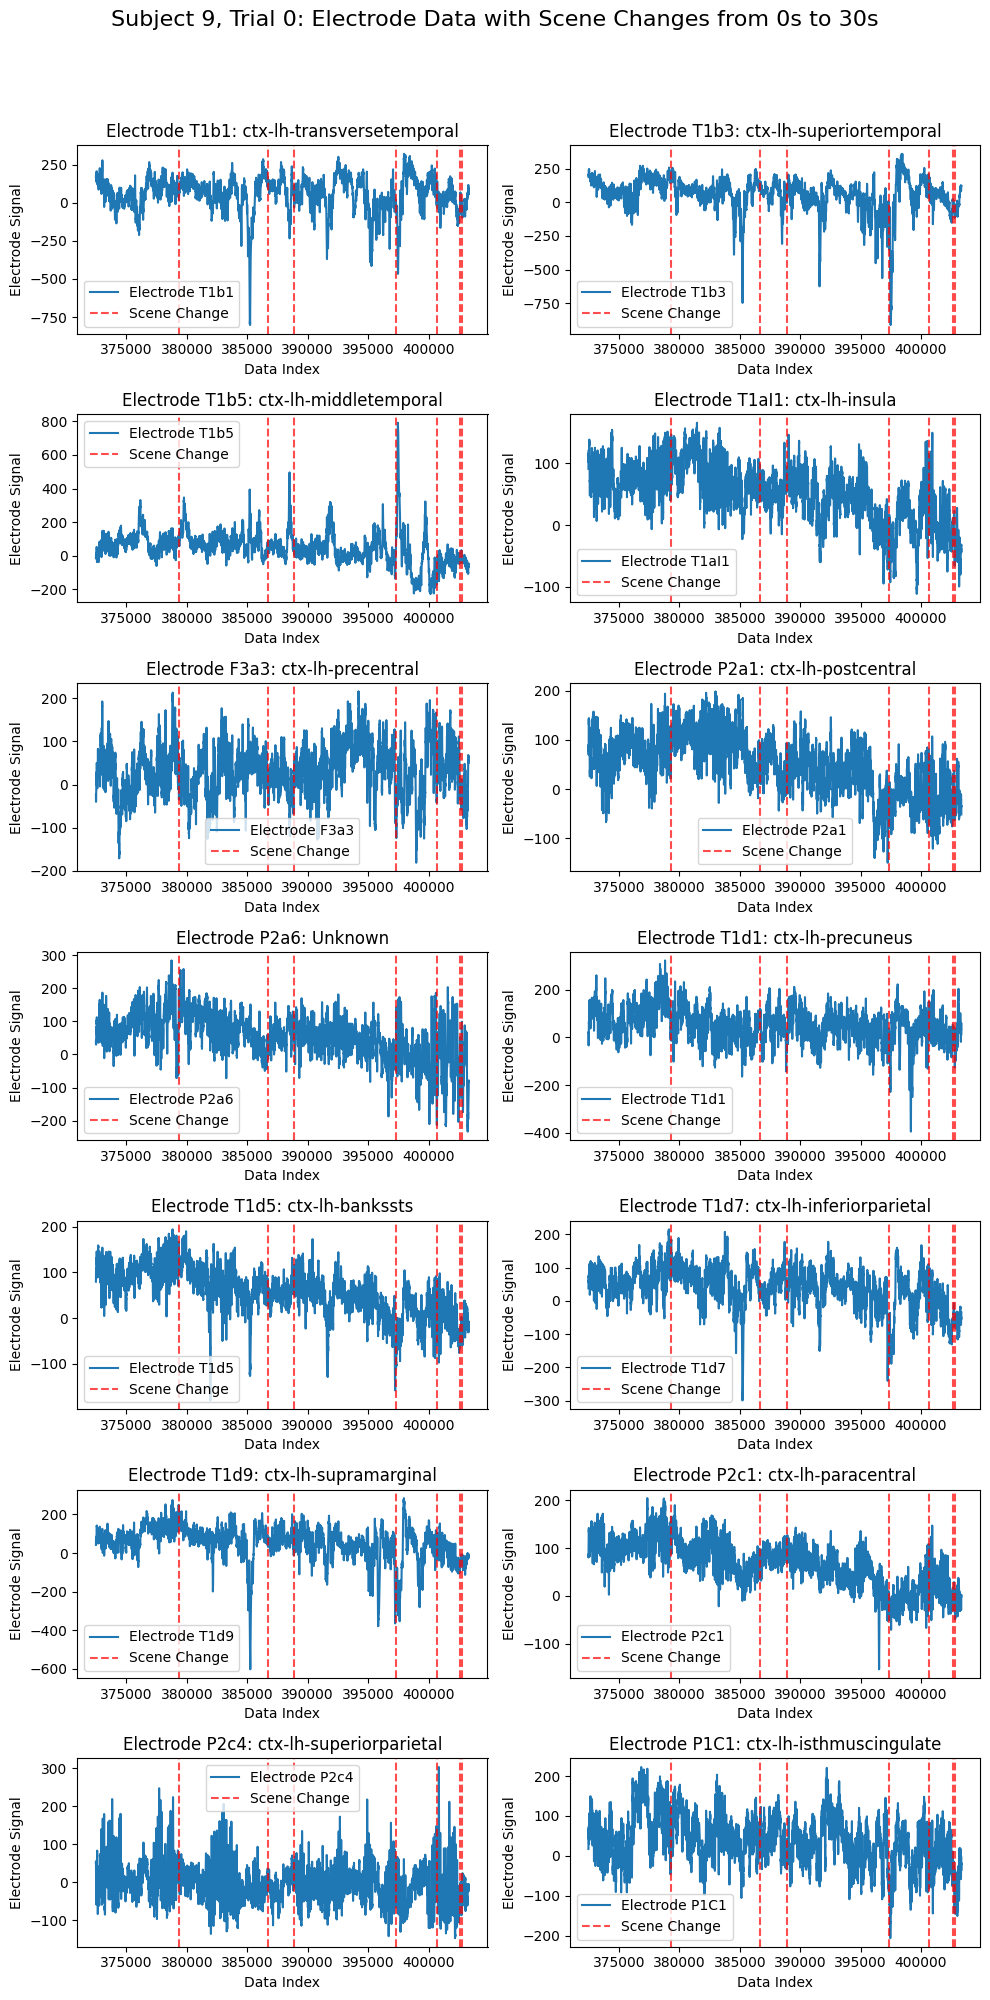

In [23]:
graph_scene_changes('ant-man.mp4', 0, 30)

Computing frame distances...
Detecting scene changes...
Generating visualizations...

Scene Analysis Summary:
Total scenes detected: 4030
Number of scene changes: 4029
Average scene duration: 2.13 seconds
Median scene duration: 1.25 seconds
Shortest scene: 0.08 seconds
Longest scene: 427.34 seconds

Scene change timestamps: ['2.09s', '4.21s', '4.30s', '4.55s', '4.75s', '4.84s', '5.26s', '6.42s', '17.43s', '18.44s', '18.60s', '20.06s', '20.19s', '20.31s', '20.48s', '21.48s', '22.19s', '22.86s', '23.02s', '23.44s', '27.03s', '30.03s', '31.95s', '32.24s', '32.32s', '32.82s', '32.91s', '33.41s', '33.53s', '34.20s', '34.83s', '35.20s', '35.29s', '35.41s', '35.49s', '36.54s', '36.66s', '36.87s', '36.95s', '37.08s', '37.16s', '37.25s', '37.41s', '37.66s', '42.63s', '43.71s', '43.96s', '44.84s', '45.71s', '45.96s', '46.50s', '46.59s', '46.84s', '47.30s', '47.38s', '49.38s', '49.51s', '49.59s', '49.80s', '50.38s', '51.72s', '52.55s', '53.01s', '53.09s', '53.26s', '53.43s', '53.55s', '53.80s', '

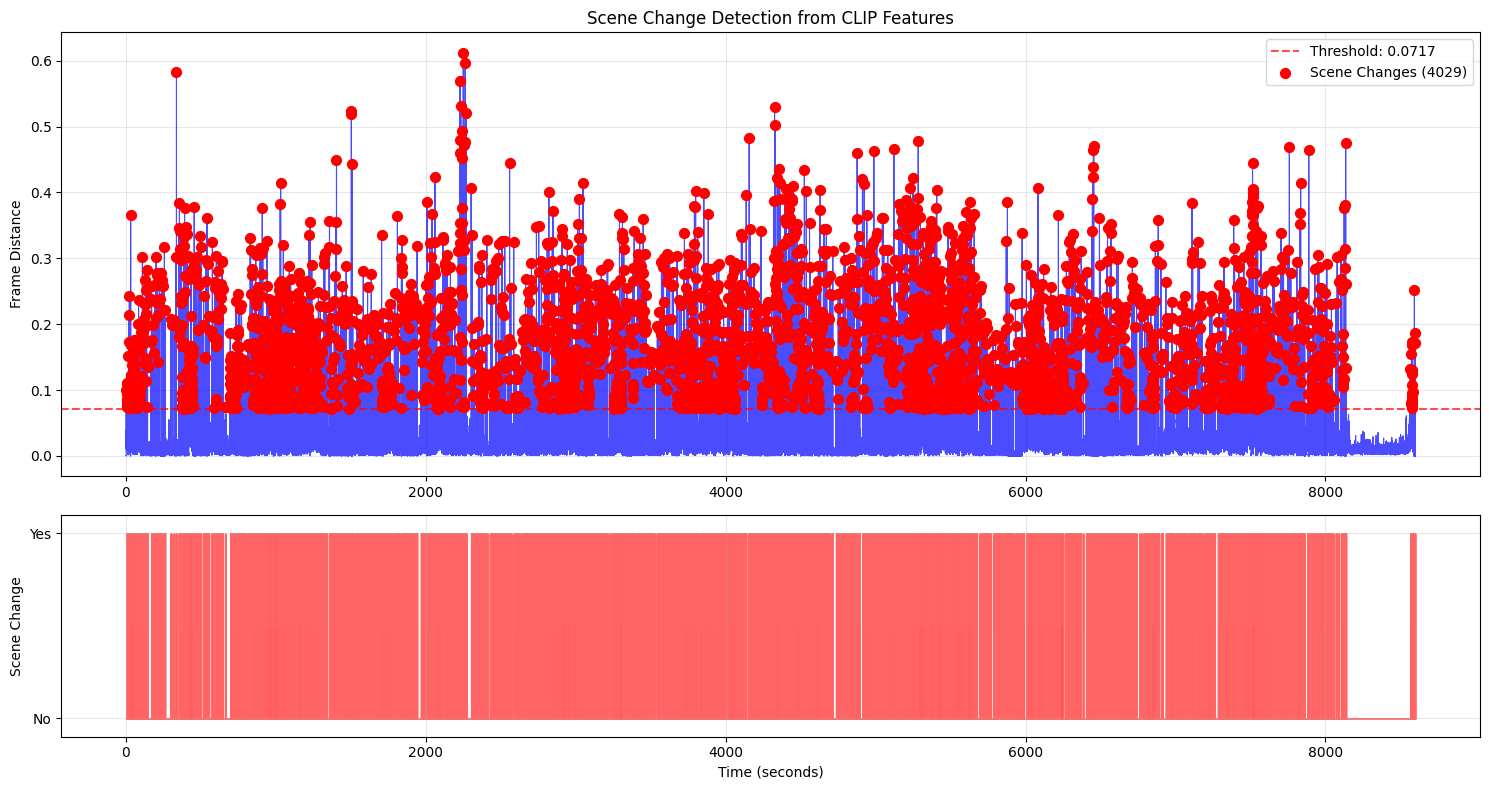

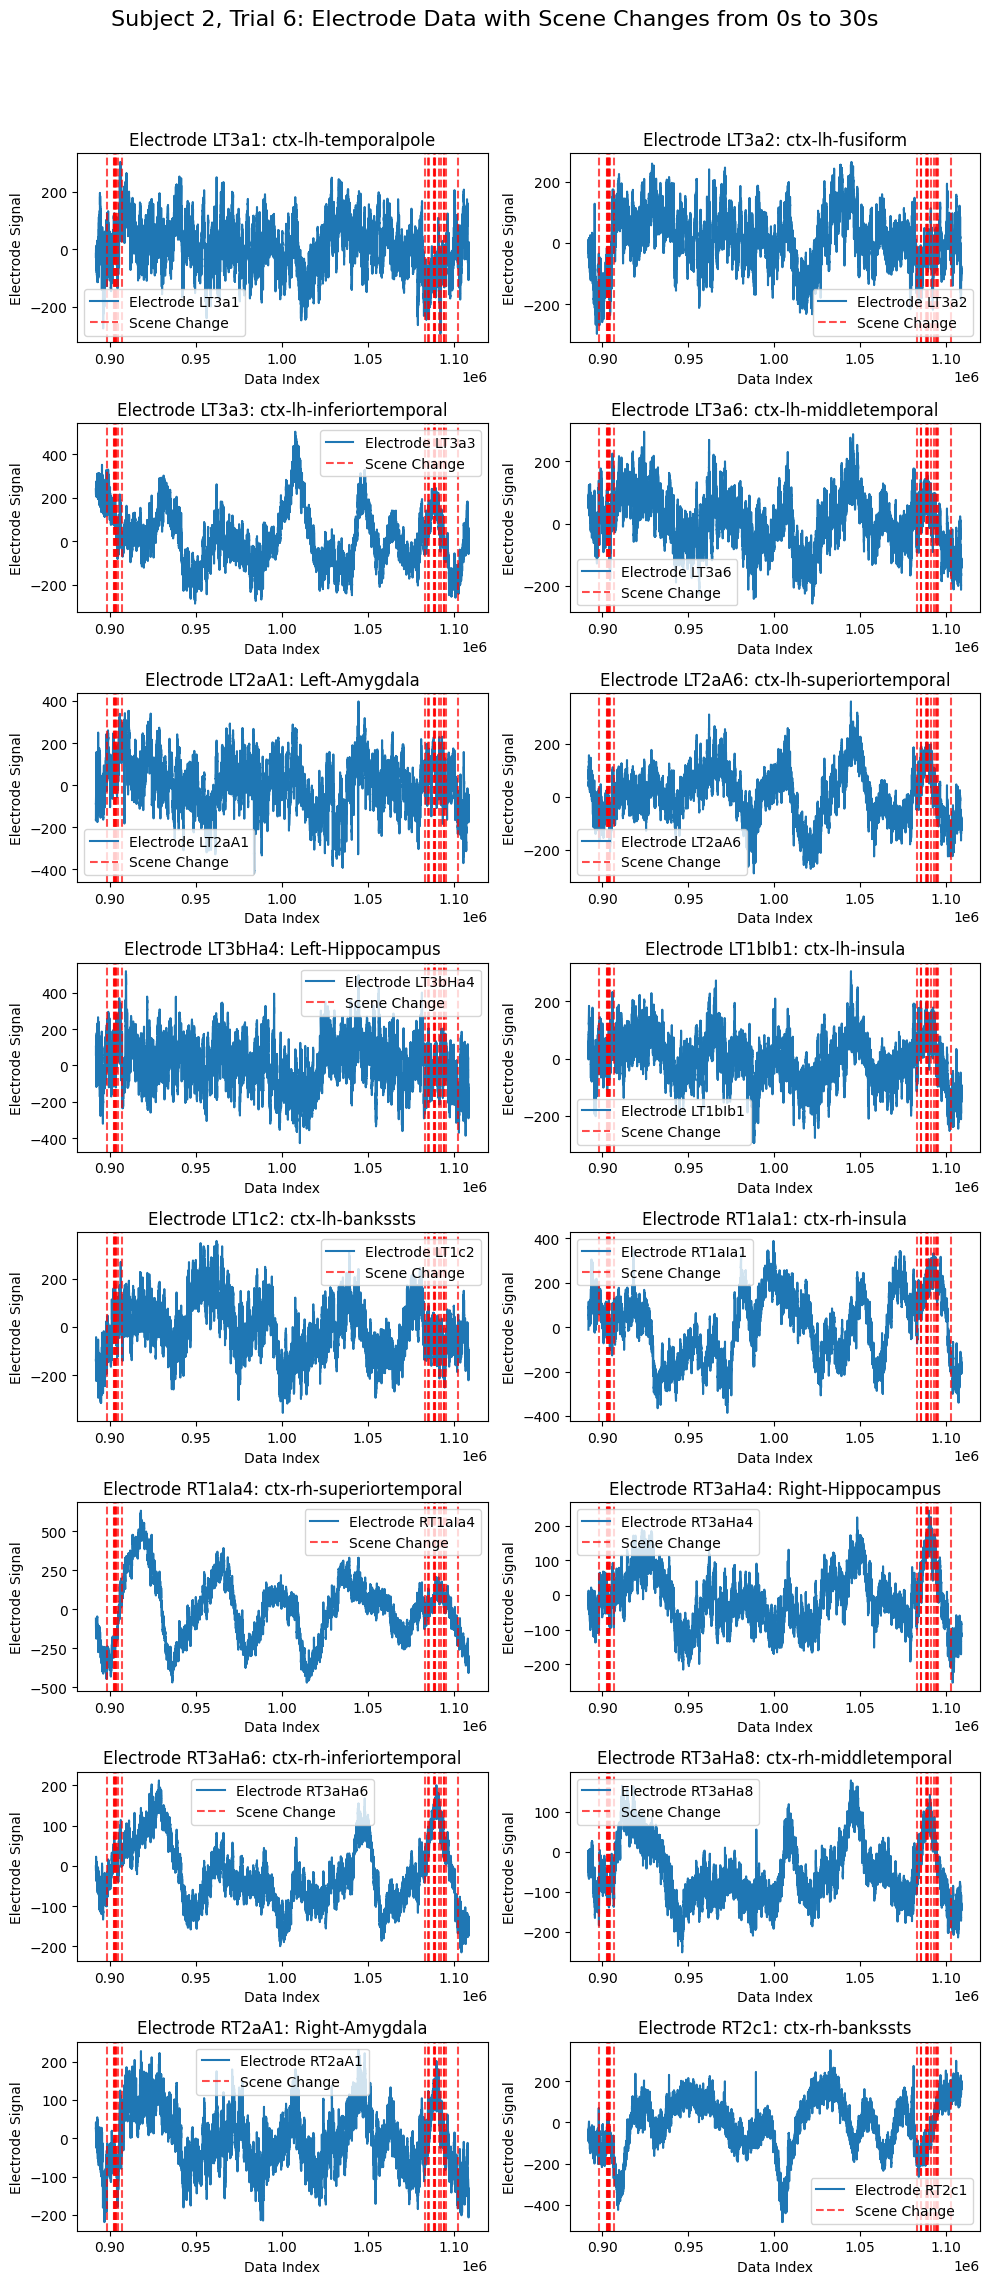

In [24]:
graph_scene_changes('aquaman.mp4', 0, 30)